In [4]:
import os

import matplotlib.pyplot as plt
import numpy as np

from keras import initializers
from keras.datasets import cifar10, mnist
from keras.initializers import RandomNormal
from keras.layers import (BatchNormalization, Conv2D, Conv2DTranspose, Dense,
                          Dropout, Flatten, Input, Reshape, UpSampling2D,
                          ZeroPadding2D)
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline

In [5]:
# Consistent results
np.random.seed(1337)

# The dimension of z
noise_dim = 100

batch_size = 16
steps_per_epoch = 312 # 50000 / 16
epochs = 800

save_path = 'dcgan-images'

img_rows, img_cols, channels = 32, 32, 3

optimizer = Adam(0.0002, 0.5)

In [6]:
# Create path for saving images
if save_path != None and not os.path.isdir(save_path):
    os.mkdir(save_path)

In [7]:
# Load and pre-process data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Normalize to between -1 and 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

# Reshape and only save cat images
x_train = x_train[np.where(y_train == 0)[0]].reshape((-1, img_rows, img_cols, channels))

170508288/170498071 [==============================] - 54s 0us/step


In [8]:
def create_generator():
    generator = Sequential()
    
    # Starting size
    d = 4
    generator.add(Dense(d*d*256, kernel_initializer=RandomNormal(0, 0.02), input_dim=noise_dim))
    generator.add(LeakyReLU(0.2))
    # 4x4x256
    generator.add(Reshape((d, d, 256)))
    
    # 8x8x128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 16x16*128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 32x32x128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    
    # 32x32x3
    generator.add(Conv2D(channels, (3, 3), padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [9]:
def create_discriminator():
    discriminator = Sequential()
    
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=(img_cols, img_rows, channels)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=(img_cols, img_rows, channels)))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [10]:
discriminator = create_discriminator()
generator = create_generator()

# Make the discriminator untrainable when we are training the generator.  This doesn't effect the discriminator by itself
discriminator.trainable = False

# Link the two models to create the GAN
gan_input = Input(shape=(noise_dim,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


In [11]:
# Display images, and save them if the epoch number is specified
def show_images(noise, epoch=None):
    generated_images = generator.predict(noise)
    plt.figure(figsize=(10, 10))
    
    for i, image in enumerate(generated_images):
        plt.subplot(10, 10, i+1)
        if channels == 1:
            plt.imshow(np.clip(image.reshape((img_rows, img_cols)), 0.0, 1.0), cmap='gray')
        else:
            plt.imshow(np.clip(image.reshape((img_rows, img_cols, channels)), 0.0, 1.0))
        plt.axis('off')
    
    plt.tight_layout()
    
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()


Epoch: 0 	 Discriminator Loss: 0.4371989667415619 		 Generator Loss: 1.8984885215759277


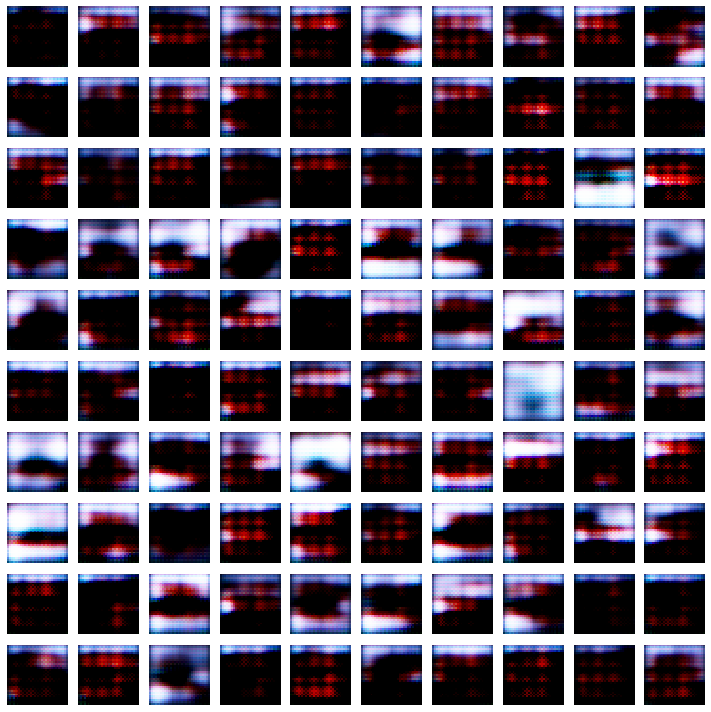

Epoch: 1 	 Discriminator Loss: 0.5636455416679382 		 Generator Loss: 1.3371851444244385
Epoch: 2 	 Discriminator Loss: 0.5639340877532959 		 Generator Loss: 1.3279352188110352


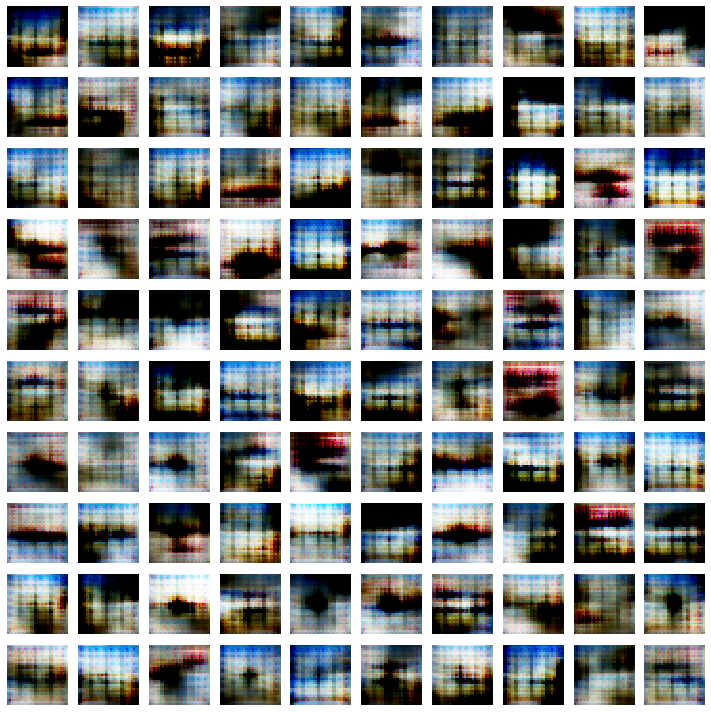

Epoch: 3 	 Discriminator Loss: 0.5653483271598816 		 Generator Loss: 1.128438115119934
Epoch: 4 	 Discriminator Loss: 0.5739746689796448 		 Generator Loss: 1.2897686958312988


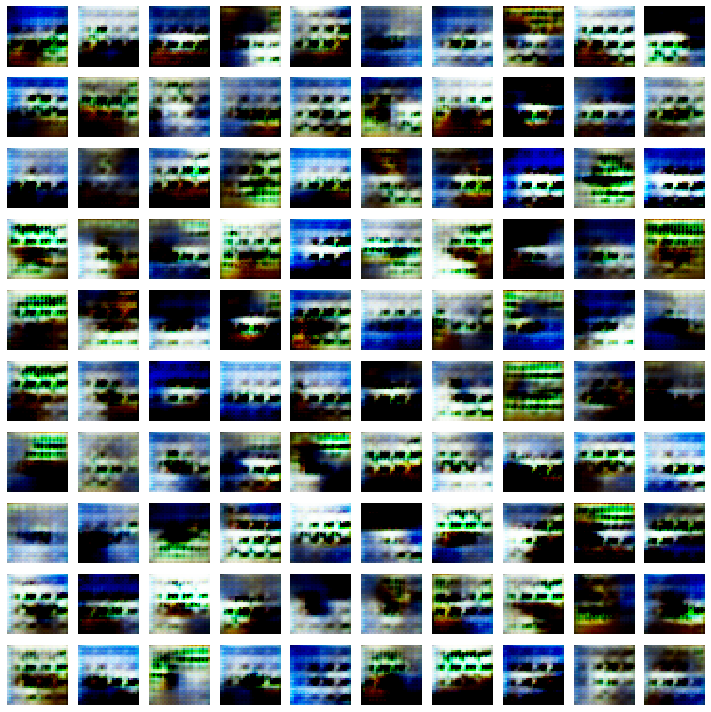

Epoch: 5 	 Discriminator Loss: 0.6563095450401306 		 Generator Loss: 1.1378471851348877
Epoch: 6 	 Discriminator Loss: 0.6388481855392456 		 Generator Loss: 1.3006476163864136


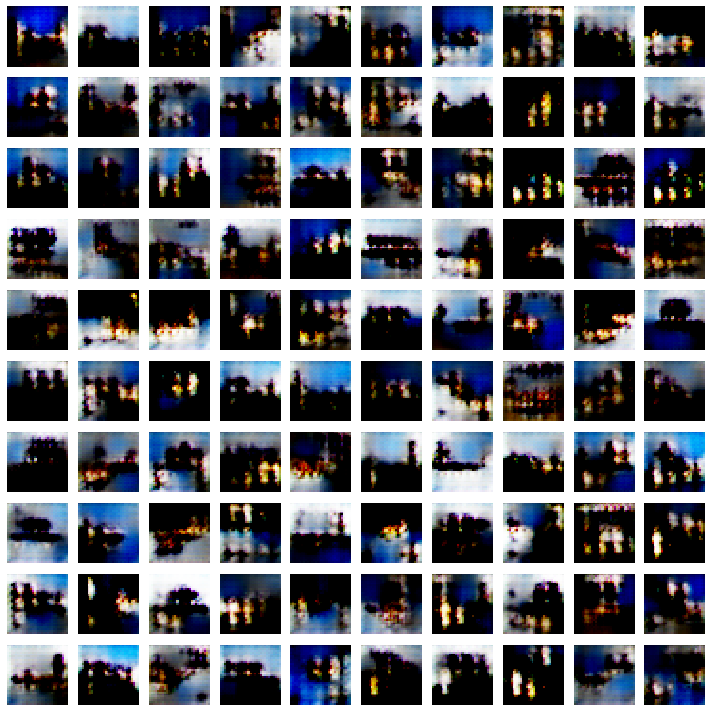

Epoch: 7 	 Discriminator Loss: 0.5938680171966553 		 Generator Loss: 1.189436435699463
Epoch: 8 	 Discriminator Loss: 0.5490591526031494 		 Generator Loss: 1.0605231523513794


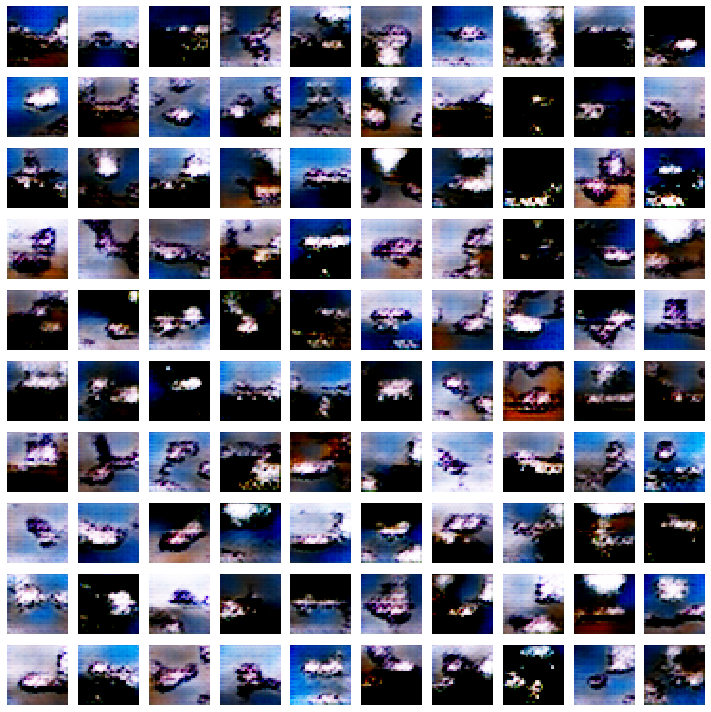

Epoch: 9 	 Discriminator Loss: 0.6283578276634216 		 Generator Loss: 1.005445957183838
Epoch: 10 	 Discriminator Loss: 0.6598072052001953 		 Generator Loss: 1.0102899074554443


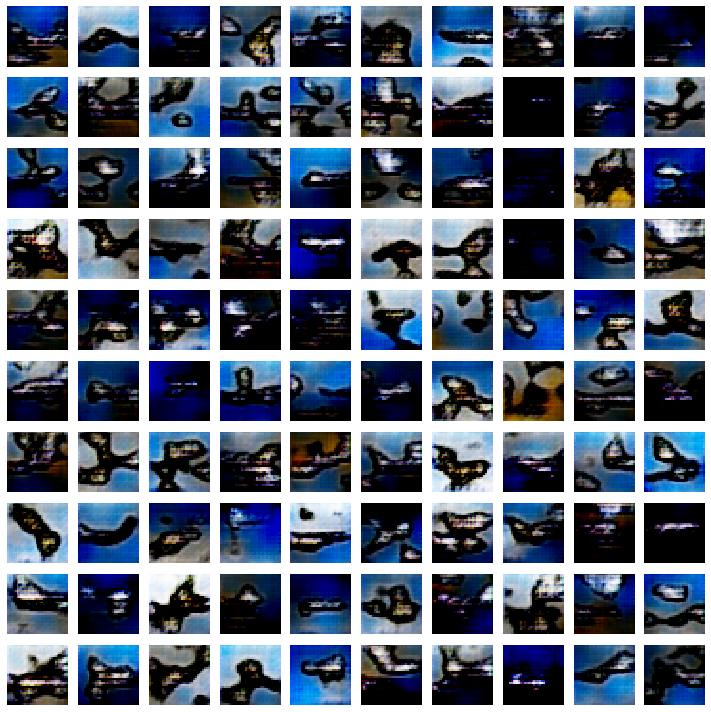

Epoch: 11 	 Discriminator Loss: 0.6697738170623779 		 Generator Loss: 1.0167611837387085
Epoch: 12 	 Discriminator Loss: 0.6845288276672363 		 Generator Loss: 1.234723448753357


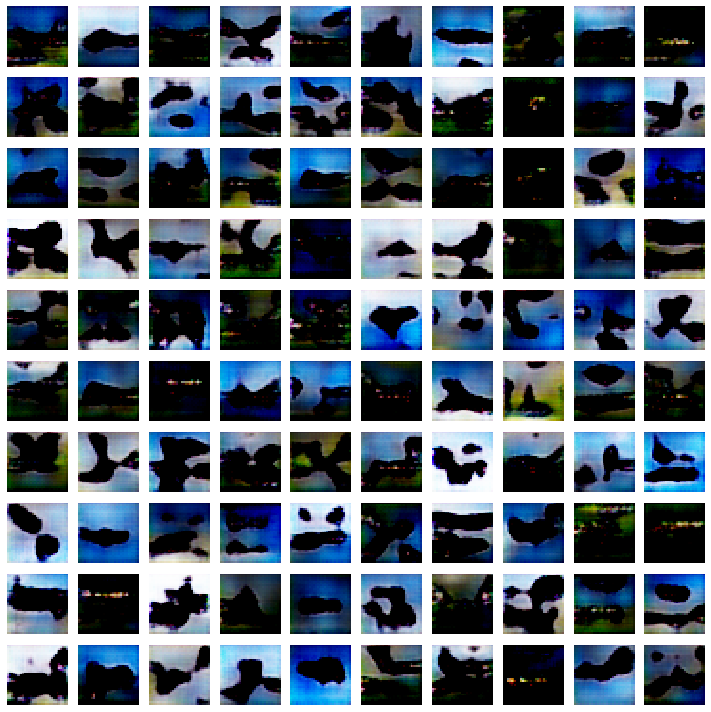

Epoch: 13 	 Discriminator Loss: 0.7183300256729126 		 Generator Loss: 1.0959947109222412
Epoch: 14 	 Discriminator Loss: 0.7416076064109802 		 Generator Loss: 1.1148927211761475


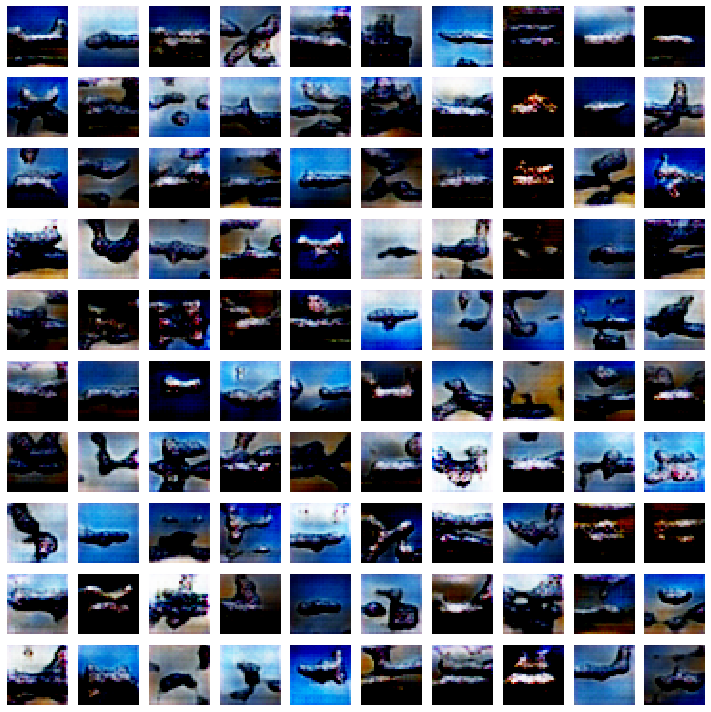

Epoch: 15 	 Discriminator Loss: 0.649811863899231 		 Generator Loss: 1.1129891872406006
Epoch: 16 	 Discriminator Loss: 0.6370296478271484 		 Generator Loss: 1.087496280670166


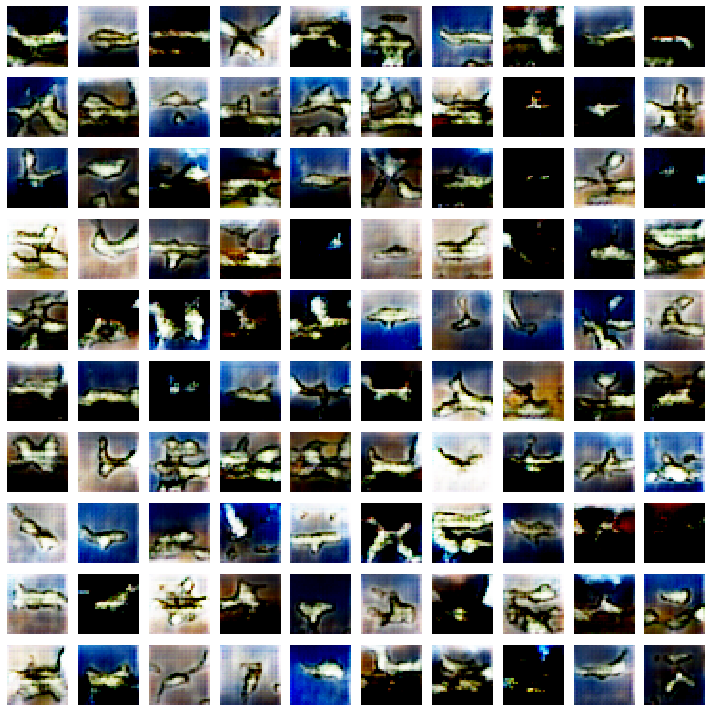

Epoch: 17 	 Discriminator Loss: 0.5786682963371277 		 Generator Loss: 0.8966091871261597
Epoch: 18 	 Discriminator Loss: 0.5939792990684509 		 Generator Loss: 0.975179135799408


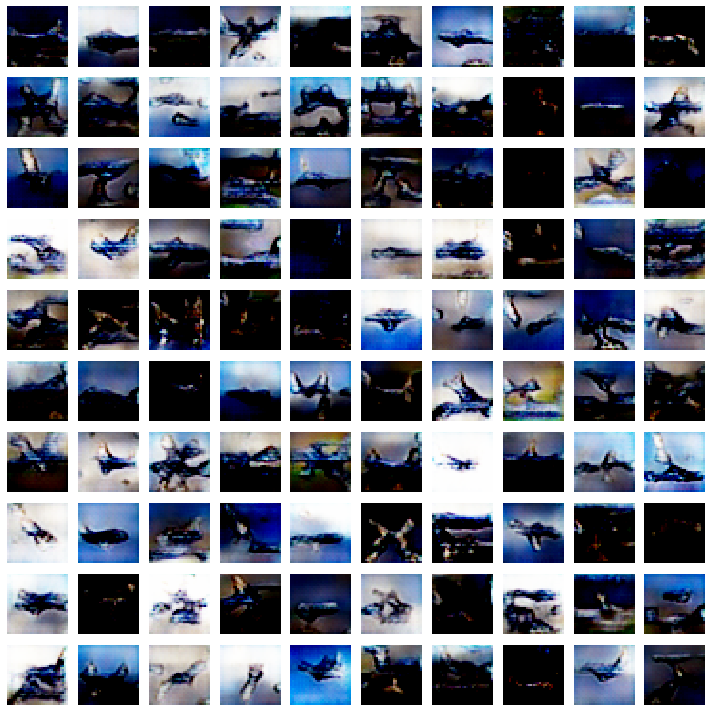

Epoch: 19 	 Discriminator Loss: 0.5310792326927185 		 Generator Loss: 1.1741743087768555
Epoch: 20 	 Discriminator Loss: 0.627858579158783 		 Generator Loss: 1.1142752170562744


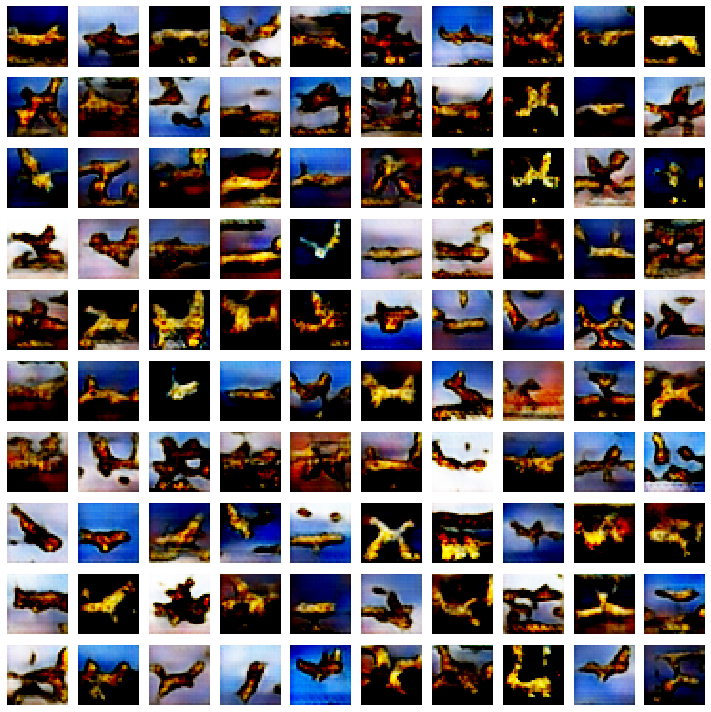

Epoch: 21 	 Discriminator Loss: 0.6508989930152893 		 Generator Loss: 1.0185000896453857
Epoch: 22 	 Discriminator Loss: 0.6998969912528992 		 Generator Loss: 1.0394995212554932


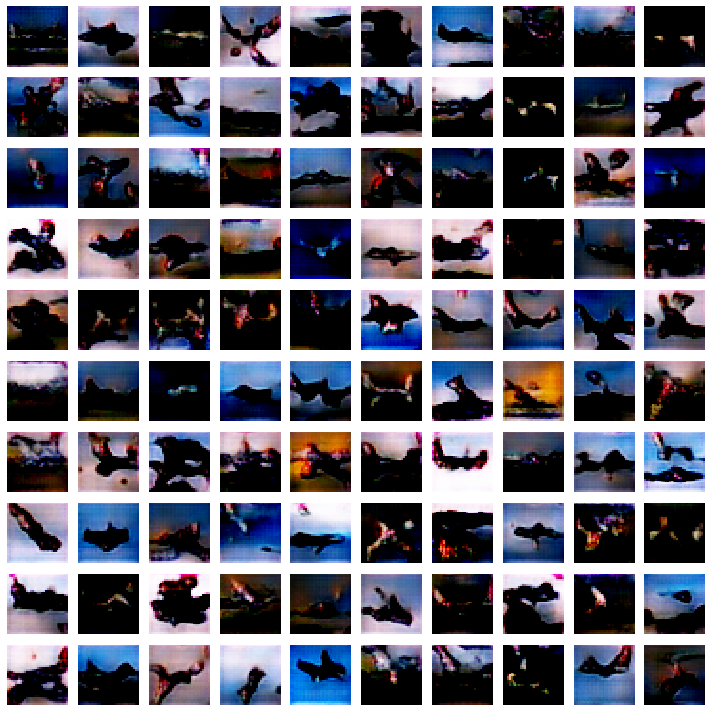

Epoch: 23 	 Discriminator Loss: 0.6333824396133423 		 Generator Loss: 1.3024275302886963
Epoch: 24 	 Discriminator Loss: 0.5575577616691589 		 Generator Loss: 1.2170644998550415


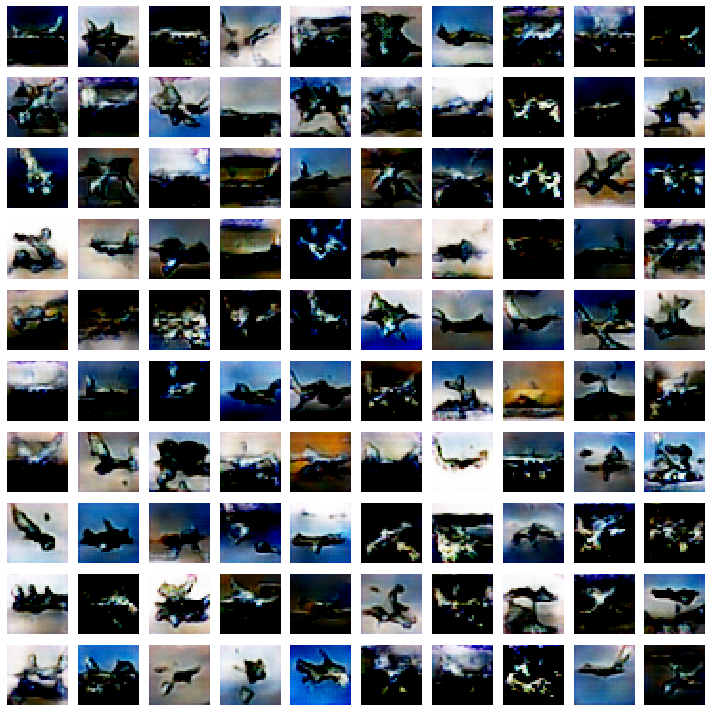

Epoch: 25 	 Discriminator Loss: 0.5673051476478577 		 Generator Loss: 1.1928417682647705
Epoch: 26 	 Discriminator Loss: 0.6375869512557983 		 Generator Loss: 1.1824538707733154


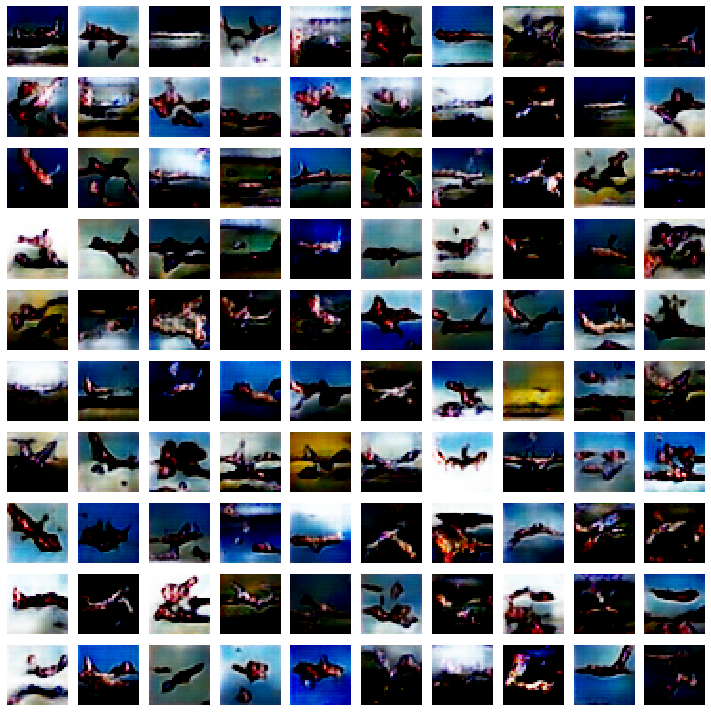

Epoch: 27 	 Discriminator Loss: 0.741675853729248 		 Generator Loss: 0.9553731679916382
Epoch: 28 	 Discriminator Loss: 0.5628823041915894 		 Generator Loss: 1.3489925861358643


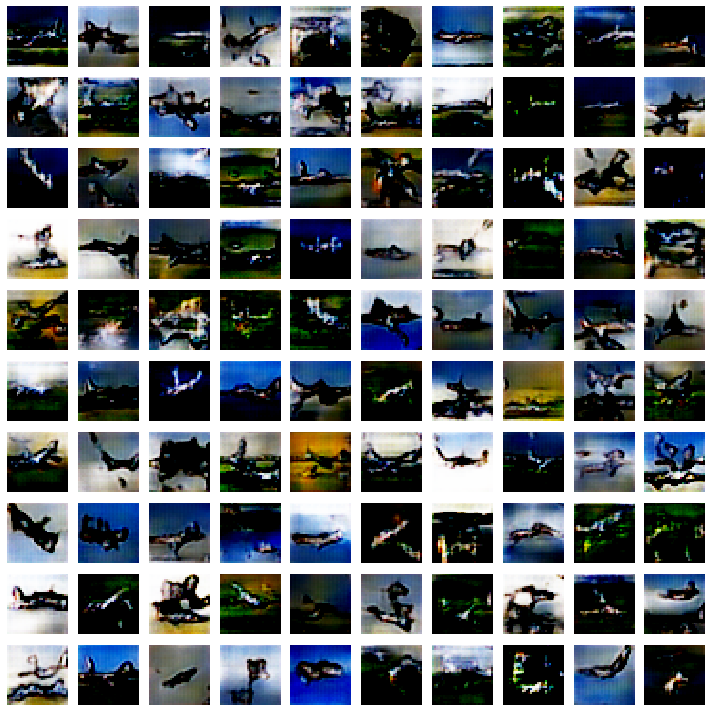

Epoch: 29 	 Discriminator Loss: 0.6630098223686218 		 Generator Loss: 1.08815598487854
Epoch: 30 	 Discriminator Loss: 0.570221483707428 		 Generator Loss: 1.7038631439208984


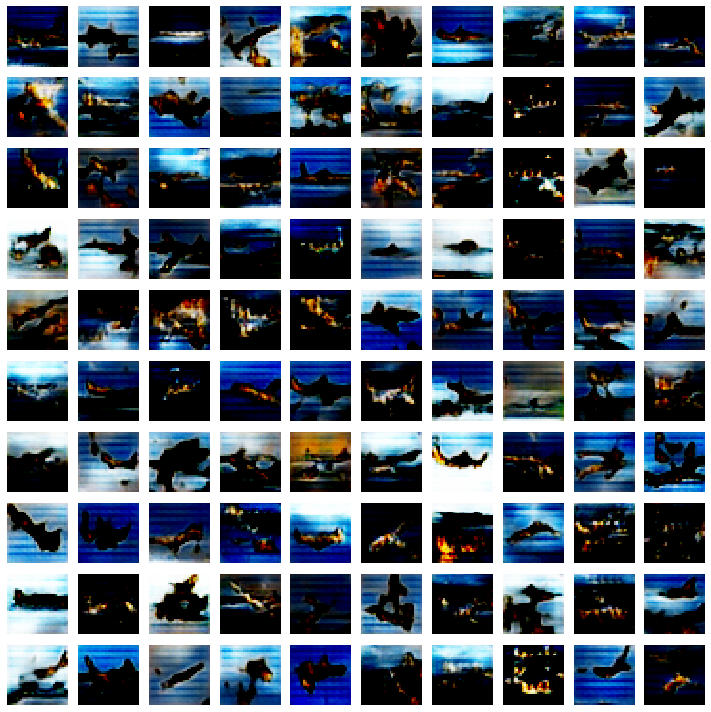

Epoch: 31 	 Discriminator Loss: 0.5709609985351562 		 Generator Loss: 1.3959749937057495
Epoch: 32 	 Discriminator Loss: 0.5713609457015991 		 Generator Loss: 1.2563002109527588


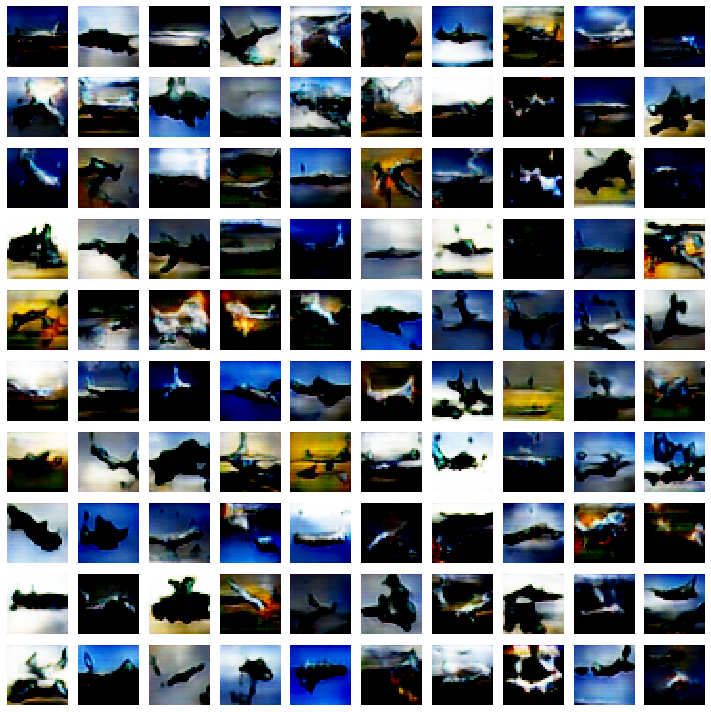

Epoch: 33 	 Discriminator Loss: 0.6081054210662842 		 Generator Loss: 1.1431190967559814
Epoch: 34 	 Discriminator Loss: 0.6407933235168457 		 Generator Loss: 0.9804339408874512


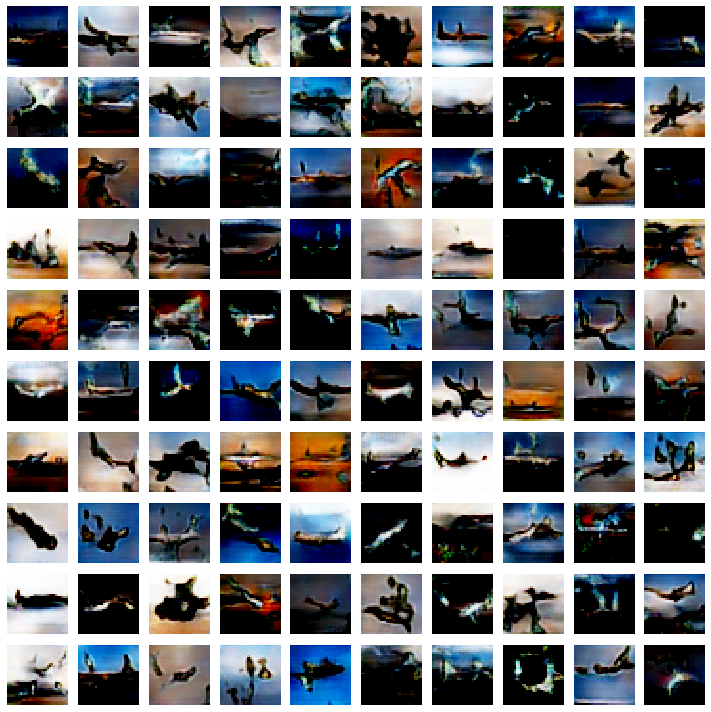

Epoch: 35 	 Discriminator Loss: 0.7235898971557617 		 Generator Loss: 1.1706022024154663
Epoch: 36 	 Discriminator Loss: 0.6363364458084106 		 Generator Loss: 1.2837638854980469


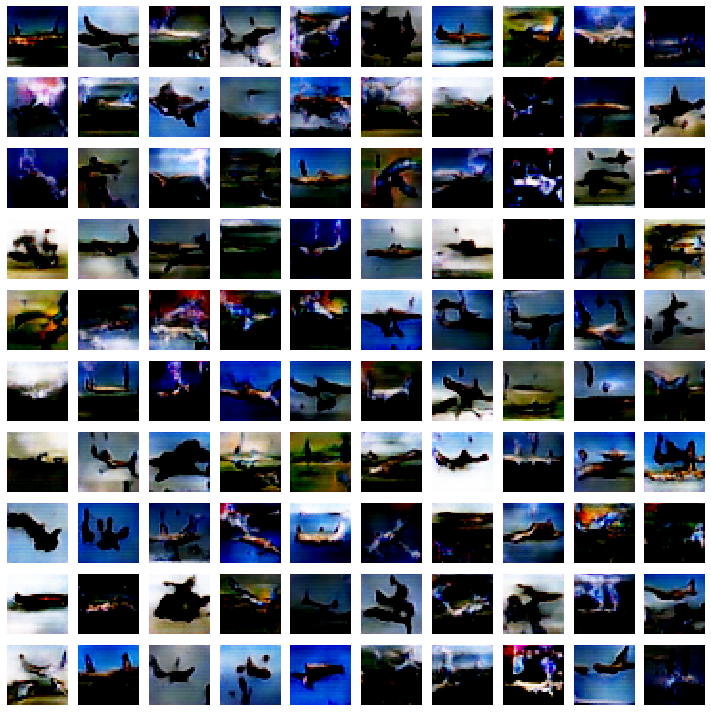

Epoch: 37 	 Discriminator Loss: 0.5660251379013062 		 Generator Loss: 1.2716047763824463
Epoch: 38 	 Discriminator Loss: 0.5736737251281738 		 Generator Loss: 1.166161060333252


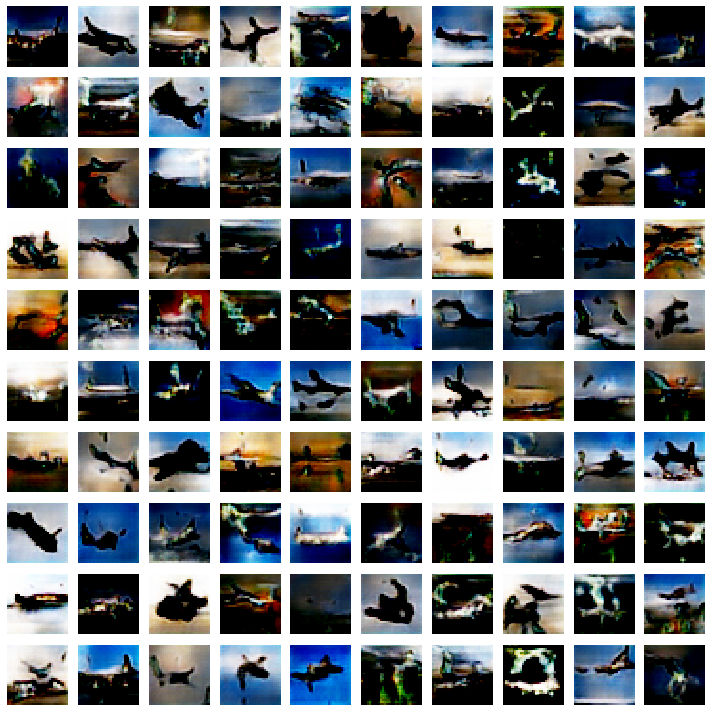

Epoch: 39 	 Discriminator Loss: 0.5933375358581543 		 Generator Loss: 1.1542952060699463
Epoch: 40 	 Discriminator Loss: 0.5769803524017334 		 Generator Loss: 1.2934759855270386


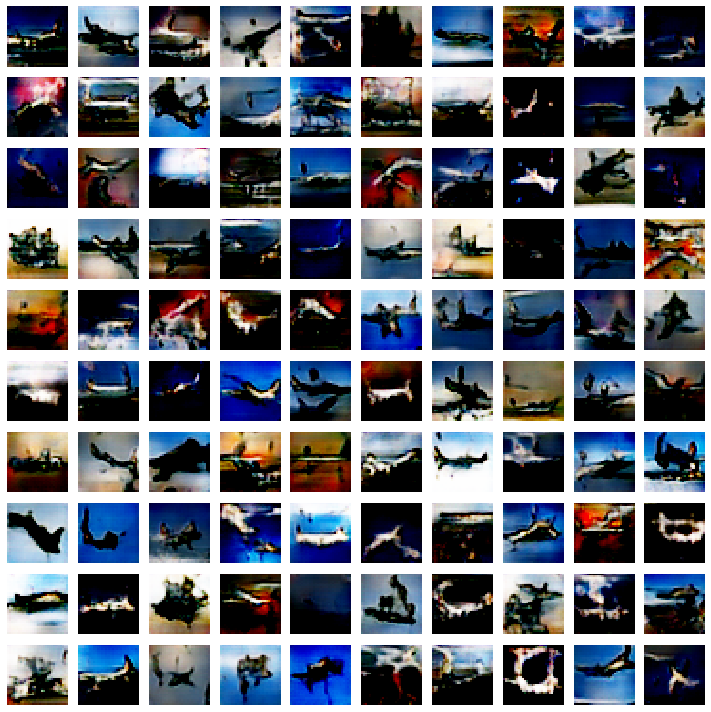

Epoch: 41 	 Discriminator Loss: 0.63371342420578 		 Generator Loss: 1.3539936542510986
Epoch: 42 	 Discriminator Loss: 0.5674470663070679 		 Generator Loss: 1.3162131309509277


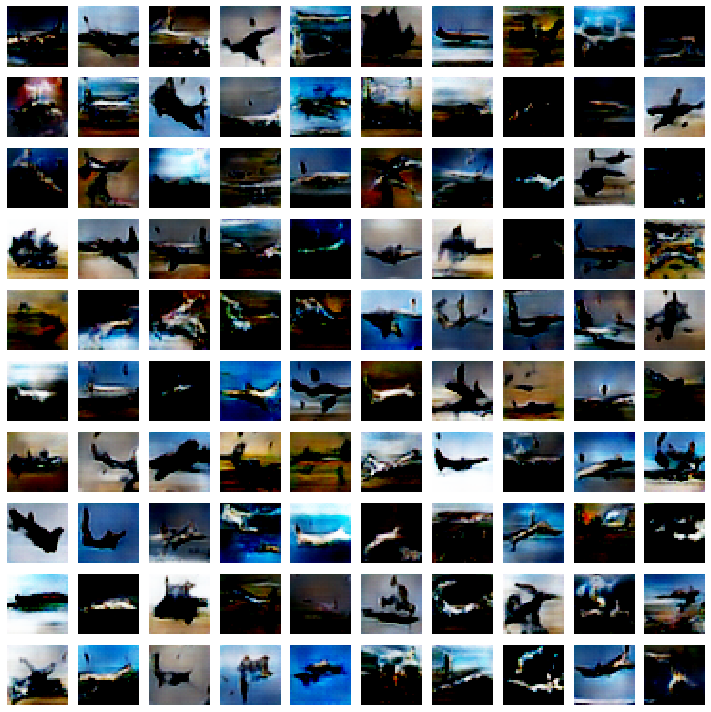

Epoch: 43 	 Discriminator Loss: 0.5430809259414673 		 Generator Loss: 1.314014196395874
Epoch: 44 	 Discriminator Loss: 0.6330349445343018 		 Generator Loss: 1.448718547821045


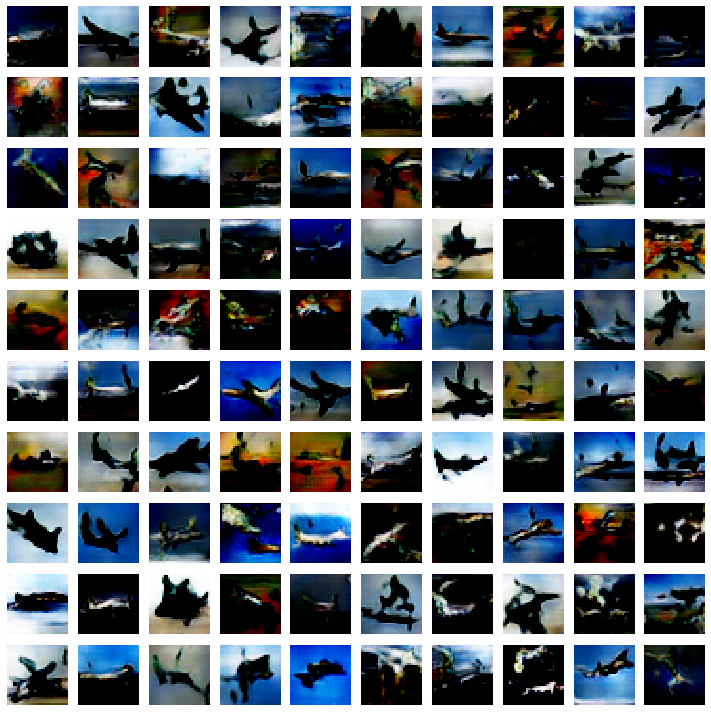

Epoch: 45 	 Discriminator Loss: 0.646801233291626 		 Generator Loss: 1.1509137153625488


In [ ]:
# Constant noise for viewing how the GAN progresses
static_noise = np.random.normal(0, 1, size=(100, noise_dim))

# Training loop
for epoch in range(epochs):
    for batch in range(steps_per_epoch):
        noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

        fake_x = generator.predict(noise)

        x = np.concatenate((real_x, fake_x))

        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9

        d_loss = discriminator.train_on_batch(x, disc_y)

        y_gen = np.ones(batch_size)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f'Epoch: {epoch} \t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
    if epoch % 2 == 0:
        show_images(static_noise, epoch)


In [ ]:
# Turn the training process into a GIF
from PIL import Image, ImageDraw

image_names = os.listdir(save_path)

frames = []
for image in sorted(image_names, key=lambda name: int(''.join(i for i in name if i.isdigit()))):
    frames.append(Image.open(save_path + '/' + image))

frames[0].save('gan_training.gif', format='GIF', append_images=frames[1:], save_all=True, duration=80, loop=0)

discriminator.save('dcdiscriminator.h5')
generator.save('dcgenerator.h5')